In [1]:
# Load GloVe model
GLOVE_PATH = "glove.6B.50d.txt"
EMBEDDING_DIM = 50

def load_word_vectors(path):
    word_vectors = dict()
    f = open(path, encoding="utf-8")
    for line in f:
        values = line.split()
        word = values[0]
        word_numbers = values[1:]
        word_vectors[word] = word_numbers
    f.close()
    print("load {} word vectors.".format(len(word_vectors)))
    return word_vectors

word_vectors = load_word_vectors(GLOVE_PATH)

load 400000 word vectors.


In [ ]:
import pandas as pd
import numpy as np

data = pd.read_csv("train.txt/train.csv", encoding="utf-8")
test_data = pd.read_csv("test.txt/text.csv", encoding="utf-8")

In [3]:
data = data.fillna(method="ffill")
data.head(10)

,Word,POS,Tag
0,Confidence,NN,B-NP
1,in,IN,B-PP
2,the,DT,B-NP
3,pound,NN,I-NP
4,is,VBZ,B-VP
5,widely,RB,I-VP
6,expected,VBN,I-VP
7,to,TO,I-VP
8,take,VB,I-VP
9,another,DT,B-NP


In [4]:
words = list(set(data["Word"].values))
words.append("ENDPAD")

In [5]:
words

['5,088',
 'supposed',
 'H&R',
 'HUD',
 'amid',
 'vacationers',
 'Columbia',
 'Studios',
 'AEW',
 'picking',
 'heir',
 '1.59',
 'Turnaround',
 'stir',
 'candles',
 'Bridge',
 'code-named',
 'A.',
 'Bombay',
 '618.9',
 'margin',
 'Guardian',
 'roadways',
 'buffs',
 'Ben',
 'NRC',
 'troops',
 'stop-loss',
 'switching',
 'deposits',
 'demands',
 '5:40',
 '190.125',
 'suffering',
 'airwaves',
 'tick',
 'Joseph',
 'constructing',
 'person',
 'state',
 'types',
 'marches',
 'policyholder',
 'pints',
 'navigator',
 'January',
 'Fine',
 'Executives',
 'touch',
 '15.4',
 'outright',
 'Engineering',
 'Lewis',
 'preferences',
 'consequence',
 'de',
 '4.2-ton',
 '62.8',
 'junction',
 '22,000',
 'Asilone',
 'specifications',
 'infiltrate',
 'Transvaal',
 '318.6',
 'Fluor',
 'managing',
 'Faced',
 'remember',
 'foot',
 'Greifswald',
 'Chinese-British',
 'unveils',
 'restricted',
 'stride',
 'Had',
 'Barclays',
 'Susie',
 'EXPECT',
 'disclosed',
 'isthmus',
 'lower-priced',
 'Geo',
 'Petrolane',
 'ch

In [6]:
tags = list(set(data["Tag"].values)); tags

['I-ADVP',
 'B-VP',
 'I-PP',
 'I-CONJP',
 'I-PRT',
 'I-INTJ',
 'B-NP',
 'B-UCP',
 'B-ADVP',
 'B-INTJ',
 'I-UCP',
 'I-ADJP',
 'B-LST',
 'B-PP',
 'B-PRT',
 'B-ADJP',
 'B-SBAR',
 'O',
 'I-NP',
 'I-VP',
 'B-CONJP',
 'I-SBAR']

In [7]:
n_words = len(words)
n_tags = len(tags)
print('n_words {}, n_tags {}'.format(n_words,n_tags))

n_words 19069, n_tags 22


In [9]:
# Grouping words into sentence.
# Input : dataframe
# Output : array of sentences.
def group_words(df):
    sentences = []
    sentence = []
    sentence_counter = 1
    sentence_ending_counter = 0
    for index, row in df.iterrows():
        tuple = (row['Word'],row['POS'],row['Tag'])

        sentence.append(tuple)
        if (row['Word'] == '.' and row['POS'] == '.' and row['Tag'] == 'O'):
            sentence_ending_counter += 1
        
        if (sentence_ending_counter > 1):
            sentences.append(sentence)                
            sentence_ending_counter = 0
            sentence = []
                            
    return sentences
    
sentences = group_words(data)
print("# sentences : {}".format(len(sentences)))

# sentences : 8448


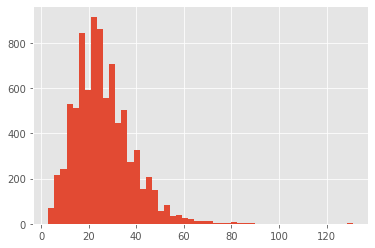

In [10]:
import matplotlib.pyplot as plt
plt.style.use("ggplot")
plt.hist([len(s) for s in sentences], bins=50)
plt.show()

In [12]:
max_len = 50
word2idx = {w: i for i, w in enumerate(words)}
tag2idx = {t: i for i, t in enumerate(tags)}
word2idx.items()

dict_items([('5,088', 0), ('supposed', 1), ('H&R', 2), ('HUD', 3), ('amid', 4), ('vacationers', 5), ('Columbia', 6), ('Studios', 7), ('AEW', 8), ('picking', 9), ('heir', 10), ('1.59', 11), ('Turnaround', 12), ('stir', 13), ('candles', 14), ('Bridge', 15), ('code-named', 16), ('A.', 17), ('Bombay', 18), ('618.9', 19), ('margin', 20), ('Guardian', 21), ('roadways', 22), ('buffs', 23), ('Ben', 24), ('NRC', 25), ('troops', 26), ('stop-loss', 27), ('switching', 28), ('deposits', 29), ('demands', 30), ('5:40', 31), ('190.125', 32), ('suffering', 33), ('airwaves', 34), ('tick', 35), ('Joseph', 36), ('constructing', 37), ('person', 38), ('state', 39), ('types', 40), ('marches', 41), ('policyholder', 42), ('pints', 43), ('navigator', 44), ('January', 45), ('Fine', 46), ('Executives', 47), ('touch', 48), ('15.4', 49), ('outright', 50), ('Engineering', 51), ('Lewis', 52), ('preferences', 53), ('consequence', 54), ('de', 55), ('4.2-ton', 56), ('62.8', 57), ('junction', 58), ('22,000', 59), ('Asilo

In [73]:
word2idx["Confidence"]

13569

In [74]:
tag2idx["B-NP"]

13

In [24]:
def create_embedding_matrix(word_index):
    vocabulary_size = len(word_index)
    embedding_matrix = np.zeros((vocabulary_size, EMBEDDING_DIM))
    for word,i in word_index.items():
        try:
            # print('word[{}] => {}'.format(i,word))
            embedding_vector = word_vectors[word]
            embedding_matrix[i] = np.array(embedding_vector)
        except KeyError:
            vec = np.zeros(EMBEDDING_DIM)
            embedding_matrix[i] = vec
    return embedding_matrix

embedding_matrix = create_embedding_matrix(word2idx)
embedding_matrix

array([[ 0.      ,  0.      ,  0.      , ...,  0.      ,  0.      ,
         0.      ],
       [ 0.53717 ,  0.21162 ,  0.098459, ...,  0.23836 , -0.1206  ,
         0.06498 ],
       [ 0.      ,  0.      ,  0.      , ...,  0.      ,  0.      ,
         0.      ],
       ...,
       [ 0.      ,  0.      ,  0.      , ...,  0.      ,  0.      ,
         0.      ],
       [ 0.18415 ,  1.2837  , -0.13315 , ..., -0.65474 , -0.25577 ,
         0.32353 ],
       [ 0.      ,  0.      ,  0.      , ...,  0.      ,  0.      ,
         0.      ]])

In [16]:
from keras.preprocessing.sequence import pad_sequences
X = [[word2idx[w[0]] for w in s] for s in sentences]
X = pad_sequences(maxlen=max_len, sequences=X, padding="post", value=n_words - 1)

In [17]:
X

array([[17099,  8966,  4015, ..., 19068, 19068, 19068],
       [ 4768,  6234,  4015, ..., 19068, 19068, 19068],
       [14118, 15821,  7587, ..., 19068, 19068, 19068],
       ...,
       [ 7699, 17801, 18376, ..., 19068, 19068, 19068],
       [ 7699, 10176, 18376, ..., 19068, 19068, 19068],
       [ 7699, 15302, 12284, ..., 19068, 19068, 19068]])

In [18]:
y = [[tag2idx[w[2]] for w in s] for s in sentences]
y = pad_sequences(maxlen=max_len, sequences=y, padding="post", value=tag2idx["O"])

In [19]:
y

array([[ 6, 13,  6, ..., 17, 17, 17],
       [17, 13,  6, ..., 17, 17, 17],
       [17,  6,  1, ..., 17, 17, 17],
       ...,
       [17,  6, 18, ..., 17, 17, 17],
       [17,  6, 18, ..., 17, 17, 17],
       [17,  6,  1, ..., 17, 17, 17]])

In [20]:
from keras.utils import to_categorical
y = [to_categorical(i, num_classes=n_tags) for i in y]

In [21]:
from sklearn.model_selection import train_test_split
X_training, X_validation, y_training, y_validation = train_test_split(X, y, test_size=0.1)

In [22]:
from keras.models import Model, Input
from keras.layers import LSTM, Embedding, Dense, TimeDistributed, Dropout, Bidirectional, Conv1D, MaxPooling1D,Flatten

In [27]:
input = Input(shape=(max_len,))
model = Embedding(input_dim=n_words, output_dim=EMBEDDING_DIM, input_length=max_len, weights=[embedding_matrix])(input)  # 50-dim embedding
model = Conv1D(128, 5, activation='relu', padding="same")(model) # padding = same so that conv-result doesn't change. (why?)
# model = MaxPooling1D(5)(model)
model = Dropout(0.1)(model)
model = Bidirectional(LSTM(units=128, return_sequences=True, recurrent_dropout=0.1))(model)  # variational biLSTM
out = TimeDistributed(Dense(n_tags, activation="softmax"))(model)  # softmax output layer

In [28]:
model = Model(input, out)
model.compile(optimizer="rmsprop", loss="categorical_crossentropy", metrics=["accuracy"])
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 50)]              0         
_________________________________________________________________
embedding_2 (Embedding)      (None, 50, 50)            953450    
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 50, 128)           32128     
_________________________________________________________________
dropout_1 (Dropout)          (None, 50, 128)           0         
_________________________________________________________________
bidirectional_1 (Bidirection (None, 50, 256)           263168    
_________________________________________________________________
time_distributed_1 (TimeDist (None, 50, 22)            5654      
Total params: 1,254,400
Trainable params: 1,254,400
Non-trainable params: 0
_________________________________________________

In [ ]:
history = model.fit(X_training, np.array(y_training), batch_size=32, epochs=3, validation_split=0.1, verbose=1)

Epoch 1/3
214/214 [==============================] - 372s 2s/step - loss: 0.7851 - accuracy: 0.7601 - val_loss: 0.2548 - val_accuracy: 0.9238
Epoch 2/3
214/214 [==============================] - 356s 2s/step - loss: 0.2330 - accuracy: 0.9301 - val_loss: 0.1721 - val_accuracy: 0.9475
Epoch 3/3
214/214 [==============================] - ETA: 0s - loss: 0.1582 - accuracy: 0.9517

In [ ]:
train_loss,train_accuracy = model.evaluate(X_training, y_training, verbose=False)
print("validation accuracy: {:.4f}".format(valid_accuracy))

In [ ]:
history = model.fit(X_training, y_training, epochs=3, verbose=1, validation_data=[X_validation,y_validation])

In [ ]:
test_loss,test_accuracy = model.evaluate(X_test, Y_test, verbose=False)
print("test accuracy: {:.4f}".format(test_accuracy))